In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
(train_data, validation_data), info = tfds.load(
    'cats_vs_dogs',
    with_info = True,
    as_supervised = True,
    split = ['train[:80%]','train[80%:]']
)

In [4]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [5]:
train_num = int(info.splits['train'].num_examples)



In [6]:
def format_image(images, labels):
  images = tf.image.resize(images, (img_size, img_size))/255
  return images, labels

batch_size = 32
img_size = 224

train_set = train_data.map(format_image).shuffle(train_num//4).batch(batch_size).prefetch(1)
val_set = validation_data.map(format_image).batch(batch_size).prefetch(1)



In [7]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape = (img_size, img_size, 3))


In [8]:
feature_extractor.trainable = False

In [9]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2, activation = 'softmax')
])

In [10]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [11]:
epochs = 3
history = model.fit(
    train_set,
    epochs = epochs,
    validation_data = val_set
)

Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


582/582 [==============================] - 55s 63ms/step - loss: 0.0521 - accuracy: 0.9830 - val_loss: 0.0337 - val_accuracy: 0.9884
Epoch 2/3
582/582 [==============================] - 46s 68ms/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 0.0308 - val_accuracy: 0.9903
Epoch 3/3
582/582 [==============================] - 49s 74ms/step - loss: 0.0251 - accuracy: 0.9916 - val_loss: 0.0337 - val_accuracy: 0.9893


In [16]:
img_batch, label_batch = next(iter(train_set.take(1)))
img_batch = img_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(img_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch,axis=-1)
predicted_labels = class_names[predicted_ids]
predicted_labels

1/1 [==============================] - 0s 28ms/step


array(['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat',
       'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog',
       'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat',
       'dog', 'dog', 'dog', 'dog', 'cat'], dtype='<U3')

In [17]:
print('labels: ', label_batch)
print('predicted labels: ', predicted_labels)

labels:  [0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0]
predicted labels:  ['cat' 'cat' 'cat' 'cat' 'cat' 'dog' 'cat' 'dog' 'cat' 'cat' 'cat' 'dog'
 'cat' 'dog' 'dog' 'dog' 'cat' 'dog' 'dog' 'cat' 'cat' 'dog' 'cat' 'cat'
 'cat' 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'cat']


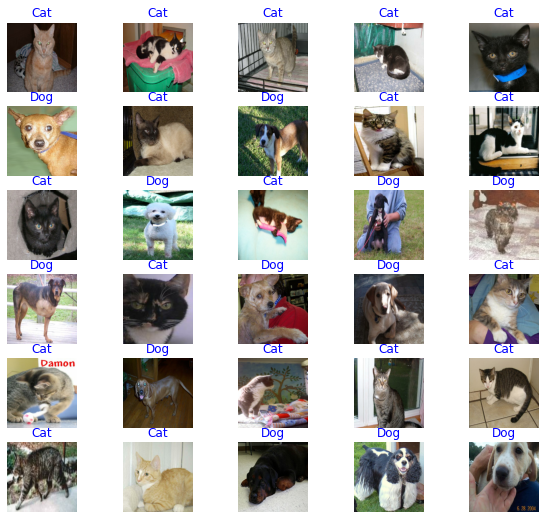

In [23]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(img_batch[n])
  color = 'blue' if predicted_ids[n]==label_batch[n] else 'red'
  plt.title(predicted_labels[n].title(), color = color)
  plt.axis('off')


In [24]:
t = time.time()
export_path_keras = './{}.h5'.format(int(t))
print(export_path_keras)
model.save(export_path_keras)

./1675486346.h5


In [25]:
!ls

1675486346.h5  sample_data


In [26]:
reloaded = tf.keras.models.load_model(
    export_path_keras,
    custom_objects = {'KerasLayer': hub.KerasLayer}
)
reloaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
result1 = model.predict(img_batch)
result2 = reloaded.predict(img_batch)

1/1 [==============================] - 0s 381ms/step


In [28]:
(abs(result1 - result2)).max()

0.0

In [29]:
epochs = 1
history = reloaded.fit(
    train_set,
    epochs = 1,
    validation_data = val_set
)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


582/582 [==============================] - 49s 68ms/step - loss: 0.0219 - accuracy: 0.9922 - val_loss: 0.0341 - val_accuracy: 0.9884


In [30]:
t = time.time()
export_path_sm = './{}'.format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1675486794


In [31]:
!ls {export_path_sm}

assets	saved_model.pb	variables


In [32]:
reload_sm = tf.saved_model.load(export_path_sm)

In [33]:
result3 = reload_sm(img_batch, training=False).numpy()

In [34]:
(abs(result1 - result3)).max()

0.0

In [35]:
reload_sm.summary()

AttributeError: ignored

In [38]:
reload_sm_k = tf.keras.models.load_model(
    export_path_sm,
    custom_objects = {'KerasLayer': hub.KerasLayer}
)
reload_sm_k.summary()

ValueError: ignored

In [37]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1675487179
